In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter
import seaborn as sns
import pickle
from tqdm import tqdm
import os

import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.signal import find_peaks


In [2]:

def temp_to_unit(key):

    unit = int(key.split('_')[-1])+1

    return 'Unit_{:04d}'.format(unit)




exp_name = 'MR-0609'

nb_trials = 10
trials =np.array([1,2,3,4,5,6,7,8,9])
nb_stimuli = 25

sampling_frequency = 20000.0

# load analog
fp = f'/user/sebert/home/Documents/Experiments/Spatiotemporal_tuning_curves/{exp_name}/analog/{exp_name}_analog.h5'
data_voltf = h5py.File(fp, 'r')
data_volt = data_voltf['Data']
data_volt = data_volt['Recording_0']
data_volt = data_volt['AnalogStream']

stim_full = data_volt['Stream_0']['ChannelData'][0]
data_voltf.close()


# load spikes
fp = f'/user/sebert/home/Documents/Experiments/Spatiotemporal_tuning_curves/{exp_name}/sorting/{exp_name}_results_curated.hdf5'
dat = h5py.File(fp, 'r')

keys = list(dat['spiketimes'].keys())
spiketimes = dat['spiketimes'] # spike times in frames
spiketimes_df = pd.DataFrame(spiketimes, columns = ['Times'])


#load events
fp = f'/user/sebert/home/Documents/Experiments/Spatiotemporal_tuning_curves/{exp_name}/sync/event_list_{exp_name}_.csv'
events = pd.read_csv(fp)

# load infodict
fpinfo = f'/user/sebert/home/Documents/Experiments/Spatiotemporal_tuning_curves/Results/{exp_name}/data.pkl'

with open(fpinfo, "rb") as handle:   #Pickling
    info = pickle.load(handle)



fpplots = f'/user/sebert/home/Documents/Experiments/Spatiotemporal_tuning_curves/Results/{exp_name}/plots/stp'
fpdata = f'/user/sebert/home/Documents/Experiments/Spatiotemporal_tuning_curves/Results/{exp_name}/data_stp.pkl'


In [3]:
# %matplotlib qt
# plt.plot(stim_stp)
# plt.eventplot(flashstarts, color = 'r')
# plt.eventplot(trialstarts, color = 'g')
# plt.eventplot(trialends, color = 'm')

In [4]:
eventsdict = {}
data = {}
stimdict = {}


# extract stp 40

In [5]:
event_stp = events.loc[events['protocol_name']=='stp_testing_40']
start = event_stp['start_event'].values[0]
end = event_stp['end_event'].values[0]

stim_stp = stim_full[start:end]
stim_stp = stim_stp >500

In [6]:
# stimulus periods 
dt = 0.02
sigma = 2

# detect flashstarts 
change = np.diff(stim_stp, prepend = 1) 
flashstarts = np.where(change == 1)[0]
flashends = np.where(change == -1)[0]

# take every 10th flashstart to get trial starts 
trialstarts =np.array(flashstarts[::10])
trialends =np.array(flashends[10::10])


# # # add delay to start
trialstarts = trialstarts -20000
trialends = trialends +20000


In [7]:


# sort tialstarts by frequency 

nb_trials = 10
nb_fqs = int(len(trialstarts)/nb_trials)
fts = []

eventsdict['40'] = {}
for i in range(nb_fqs):
  
    trialss = trialstarts[i*nb_trials:i*nb_trials+nb_trials]
    trialse = trialends[i*nb_trials:i*nb_trials+nb_trials]

    flashss = flashstarts[i*10*nb_trials:i*10*nb_trials+10]
    per = (flashss[1]-flashss[0])/20000
    evt = np.round(1/per)
    print(evt)
    fts.append(evt)

    eventsdict['40'][f'{evt}'] = {}

 

    eventsdict['40'][f'{evt}']['start'] = trialss
    eventsdict['40'][f'{evt}']['end'] = trialse


stimdict['40'] = {}
# get stimulus by frequency 
for i,evt in enumerate(fts):
    stimdict['40'][f'{evt}'] = {}
    for nb in range(nb_trials):
        s =  eventsdict['40'][f'{evt}']['start'][nb]
        e =  eventsdict['40'][f'{evt}']['end'][nb]

        stim = stim_stp[s:e]
        nbsti =len(stim)
        duration = nbsti*(1/sampling_frequency)
        stimtime = np.arange(0,nbsti)*(1/sampling_frequency)
        responsetime = np.arange(0,duration,dt)
        bin_edges = np.append(responsetime, 2 * responsetime[-1] - responsetime[-2])

        stimdict['40'][f'{evt}']['stimulus'] = stim
        stimdict['40'][f'{evt}']['stimtime'] = stimtime
        stimdict['40'][f'{evt}']['time'] = responsetime
        stimdict['40'][f'{evt}']['bin_edges'] = bin_edges


# get spikes by frequency 
data['40'] = {}
for key in tqdm(spiketimes):


    spiketimes_df = pd.DataFrame(spiketimes[key][()], columns = ['Times'])
    spikes_stp = spiketimes_df.query(f"Times>={start} & Times<={end}")-start

    key = temp_to_unit(key)

    data['40'][key] = {}

    data['40'][key]["counts"] = []
    data['40'][key]["rasters"] = []
    
    for i,evt in enumerate(fts):

        raster = []
        bin_edges = stimdict['40'][f'{evt}']['bin_edges']

        for nb in range(nb_trials):

            s =  eventsdict['40'][f'{evt}']['start'][nb]
            e =  eventsdict['40'][f'{evt}']['end'][nb]

            spikes = spikes_stp.query(f"Times>={s} & Times<={e}") - s
            spikes = spikes.div(sampling_frequency)
            raster.append(np.asarray(spikes['Times']))
        
        all_spikes  = np.concatenate(raster, axis= 0)
        count, bins = np.histogram(all_spikes, bins=bin_edges, density=False) 
        count_smooth = gaussian_filter(count,sigma)/10
        data['40'][key]["counts"].append(count_smooth)
        data['40'][key]["rasters"].append(raster)
        





2.0
4.0
6.0
8.0
13.0
17.0


  0%|          | 0/217 [00:00<?, ?it/s]

100%|██████████| 217/217 [00:13<00:00, 16.49it/s]


# extact stp

In [8]:
event_stp = events.loc[events['protocol_name']=='stp_testing']
start = event_stp['start_event'].values[0]
end = event_stp['end_event'].values[0]

stim_stp = stim_full[start:end]
stim_stp = stim_stp >500

In [9]:


# detect flashstarts 
change = np.diff(stim_stp, prepend = 1) 
flashstarts = np.where(change == 1)[0]
flashends = np.where(change == -1)[0]

# take every 10th flashstart to get trial starts 
trialstarts =np.array(flashstarts[::10])
trialends =np.array(flashends[10::10])

# # # add delay to start
trialstarts = trialstarts -20000
trialends = trialends +20000


# sort tialstarts by frequency 

nb_trials = 10
nb_fqs = len(fts)

eventsdict['eq'] = {}
for i,evt in enumerate(fts):
    eventsdict['eq'][f'{evt}'] = {}
  
    trialss = trialstarts[i*nb_trials:i*nb_trials+nb_trials]
    trialse = trialends[i*nb_trials:i*nb_trials+nb_trials]
 

    eventsdict['eq'][f'{evt}']['start'] = trialss
    eventsdict['eq'][f'{evt}']['end'] = trialse


stimdict['eq'] = {}
# get stimulus by frequency 
for i,evt in enumerate(fts):
    stimdict['eq'][f'{evt}'] = {}
    for nb in range(nb_trials):
        s =  eventsdict['eq'][f'{evt}']['start'][nb]
        e =  eventsdict['eq'][f'{evt}']['end'][nb]

        stim = stim_stp[s:e]
        nbsti =len(stim)
        duration = nbsti*(1/sampling_frequency)
        stimtime = np.arange(0,nbsti)*(1/sampling_frequency)
        responsetime = np.arange(0,duration,dt)
        bin_edges = np.append(responsetime, 2 * responsetime[-1] - responsetime[-2])

        stimdict['eq'][f'{evt}']['stimulus'] = stim
        stimdict['eq'][f'{evt}']['stimtime'] = stimtime
        stimdict['eq'][f'{evt}']['time'] = responsetime
        stimdict['eq'][f'{evt}']['bin_edges'] = bin_edges


# get spikes by frequency 
data['eq'] = {}
for key in tqdm(spiketimes):


    spiketimes_df = pd.DataFrame(spiketimes[key][()], columns = ['Times'])
    spikes_stp = spiketimes_df.query(f"Times>={start} & Times<={end}")-start

    key = temp_to_unit(key)

    data['eq'][key] = {}

    data['eq'][key]["counts"] = []
    data['eq'][key]["rasters"] = []
    for i,evt in enumerate(fts):

        raster = []
        bin_edges = stimdict['eq'][f'{evt}']['bin_edges']

        for nb in range(nb_trials):

            s =  eventsdict['eq'][f'{evt}']['start'][nb]
            e =  eventsdict['eq'][f'{evt}']['end'][nb]

            spikes = spikes_stp.query(f"Times>={s} & Times<={e}") - s
            spikes = spikes.div(sampling_frequency)
            raster.append(np.asarray(spikes['Times']))
        
        all_spikes  = np.concatenate(raster, axis= 0)
        count, bins = np.histogram(all_spikes, bins=bin_edges, density=False) 
        count_smooth = gaussian_filter(count,sigma)/10
        data['eq'][key]["counts"].append(count_smooth)
        data['eq'][key]["rasters"].append(raster)
        





  0%|          | 0/217 [00:00<?, ?it/s]

100%|██████████| 217/217 [00:12<00:00, 16.74it/s]


# save plots

In [10]:
fontsize = 20

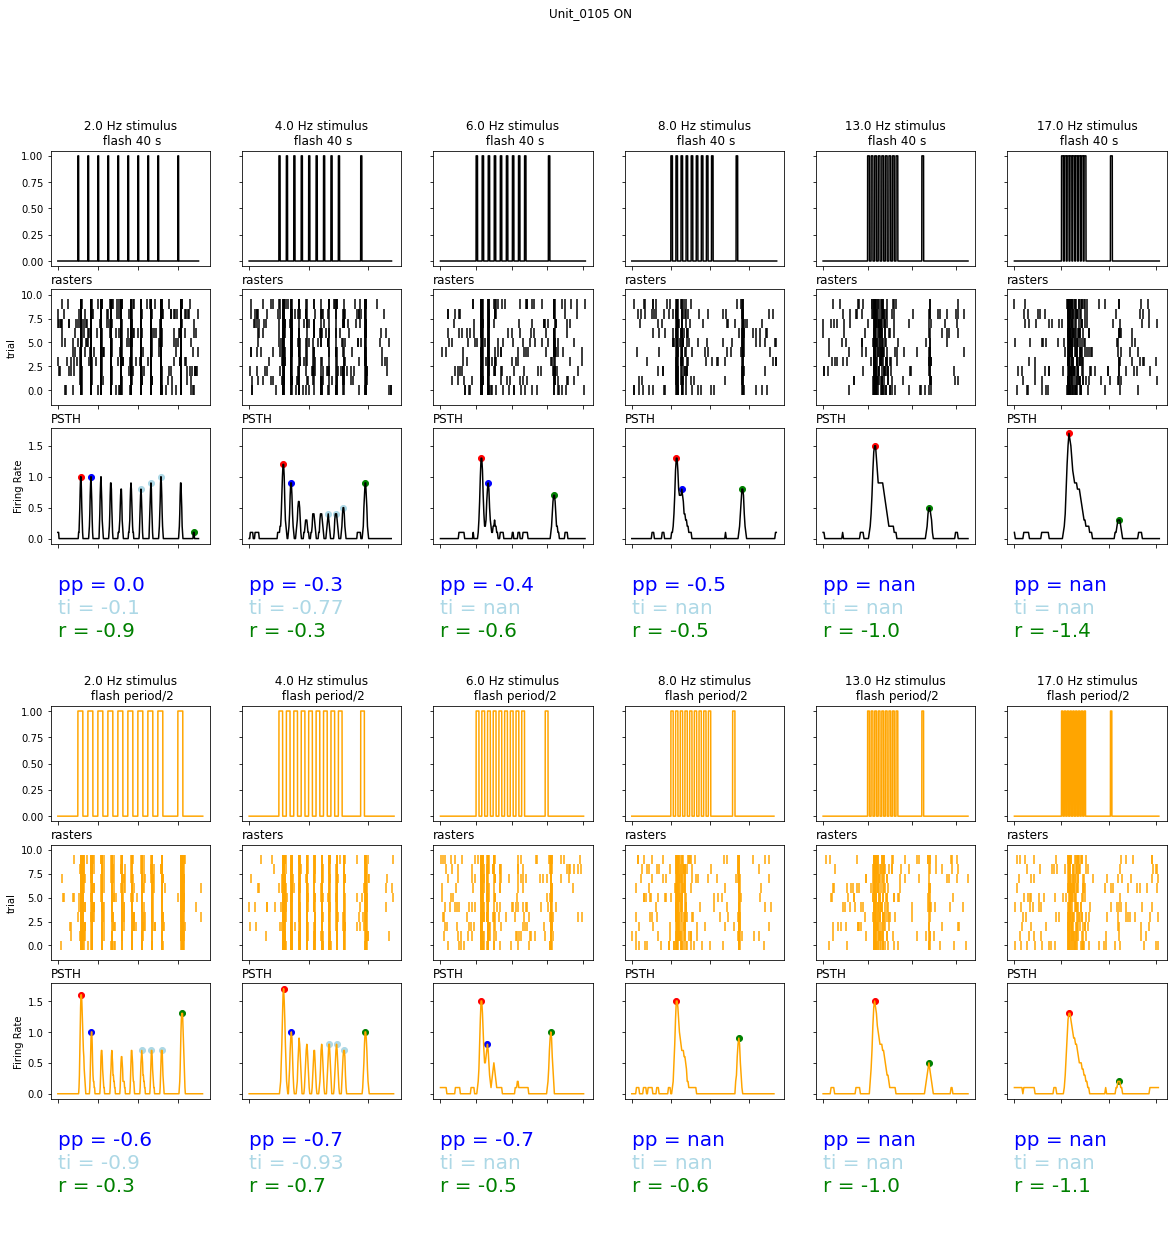

In [11]:
key = 'Unit_0105'
fig,ax = plt.subplots(8,6, sharex = 'col',sharey = 'row', figsize = (20,20))
rasters = data['40'][key]['rasters']
counts = data['40'][key]['counts']

for i,frt in enumerate(stimdict['40']):
    time = stimdict['40'][frt]['time']
    if i ==0:
        ax[0,i].plot(stimdict['40'][frt]['stimtime'],stimdict['40'][frt]['stimulus'], color = 'k')
        ax[0,i].set_title(f' {frt} Hz stimulus \n flash 40 s')
    else:
        ax[0,i].plot(stimdict['40'][frt]['stimtime'],stimdict['40'][frt]['stimulus'], color = 'k')
        ax[0,i].set_title(f' {frt} Hz stimulus \n flash 40 s')


    ax[1,i].eventplot(rasters[i], color = 'k')
    ax[1,i].set_title(f'rasters', loc = 'left')

    ax[2,i].plot(time,counts[i], color = 'k')
    ax[2,i].set_title(f'PSTH', loc = 'left')

    
    seuil = np.mean(counts[i][:50])+ 3*np.std(counts[i][:50])

    peaks,heights = find_peaks(counts[i], height = seuil)

    try:
        first = [time[peaks[0]], heights['peak_heights'][0]]
    except:
        first = [np.nan,np.nan]


    try:
        if len(peaks)>2:
            second = [time[peaks[1]], heights['peak_heights'][1]]
        else:
            second = [np.nan,np.nan]

            
    except:
        second = [np.nan,np.nan]

    try:
        recovery = [time[peaks[-1]], heights['peak_heights'][-1]]
    except:
        recovery = [np.nan,np.nan]


    try:
        last = [[time[peaks[6]],time[peaks[7]],time[peaks[8]]], [heights['peak_heights'][6],heights['peak_heights'][7],heights['peak_heights'][8]]]
        last_mean = [np.mean([time[peaks[6]],time[peaks[7]],time[peaks[8]]]), np.mean([heights['peak_heights'][6],heights['peak_heights'][7],heights['peak_heights'][8]])]
    except:
        last = [[np.nan,np.nan],[np.nan,np.nan],[np.nan,np.nan]]
        last_mean = [np.nan,np.nan]


    pp = second[1]-first[1]
    ti = last_mean[1]-first[1]
    r = recovery[1]-first[1]

    ax[2,i].scatter(first[0],first[1], color = 'r')
    ax[2,i].scatter(second[0],second[1], color = 'b')
    ax[2,i].scatter(recovery[0],recovery[1], color = 'g')
    ax[2,i].scatter(last[0],last[1], color = 'lightblue')

    # print values 
    ax[3,i].axis('off')
    ax[3,i].text(0.0,0.8,f'pp = {np.round(pp,2)} ',fontsize = fontsize, color = 'b')
    ax[3,i].text(0.0,0.6,f'ti = {np.round(ti,2)} ',fontsize = fontsize, color = 'lightblue')
    ax[3,i].text(0.0,0.4,f'r = {np.round(r,2)} ',fontsize = fontsize, color = 'green')


    # save values
    data['40'][key]['first'] = first
    data['40'][key]['second'] = second
    data['40'][key]['last'] = last
    data['40'][key]['recovery'] = recovery

    data['40'][key]['pp'] = pp
    data['40'][key]['ti'] = ti
    data['40'][key]['r'] = r



rasters = data['eq'][key]['rasters']
counts = data['eq'][key]['counts']
for i,frt in enumerate(stimdict['40']):
    time = stimdict['eq'][frt]['time']
    if i ==0:
        ax[4,i].plot(stimdict['eq'][frt]['stimtime'],stimdict['eq'][frt]['stimulus'], color = 'orange')
        ax[4,i].set_title(f' {frt} Hz stimulus \n flash period/2')

    else:
        ax[4,i].plot(stimdict['eq'][frt]['stimtime'],stimdict['eq'][frt]['stimulus'], color = 'orange')
        ax[4,i].set_title(f' {frt} Hz stimulus \n flash period/2')

    ax[5,i].eventplot(rasters[i], color = 'orange')
    ax[5,i].set_title(f'rasters', loc = 'left')


    ax[6,i].plot(time,counts[i], color = 'orange')
    ax[6,i].set_title(f'PSTH', loc = 'left')

    ax[-1,i].set_xlabel('time [s]')

    seuil = np.mean(counts[i][:50])+ 3*np.std(counts[i][:50])

    peaks,heights = find_peaks(counts[i], height = seuil)

    try:
        first = [time[peaks[0]], heights['peak_heights'][0]]
    except:
        first = [np.nan,np.nan]


    try:
        if len(peaks)>2:
            second = [time[peaks[1]], heights['peak_heights'][1]]
        else:
            second = [np.nan,np.nan]

            
    except:
        second = [np.nan,np.nan]

    try:
        recovery = [time[peaks[-1]], heights['peak_heights'][-1]]
    except:
        recovery = [np.nan,np.nan]


    try:
        last = [[time[peaks[6]],time[peaks[7]],time[peaks[8]]], [heights['peak_heights'][6],heights['peak_heights'][7],heights['peak_heights'][8]]]
        last_mean = [np.mean([time[peaks[6]],time[peaks[7]],time[peaks[8]]]), np.mean([heights['peak_heights'][6],heights['peak_heights'][7],heights['peak_heights'][8]])]
    except:
        last = [[np.nan,np.nan],[np.nan,np.nan],[np.nan,np.nan]]
        last_mean = [np.nan,np.nan]


    pp = second[1]-first[1]
    ti = last_mean[1]-first[1]
    r = recovery[1]-first[1]

    ax[6,i].scatter(first[0],first[1], color = 'r')
    ax[6,i].scatter(second[0],second[1], color = 'b')
    ax[6,i].scatter(recovery[0],recovery[1], color = 'g')
    ax[6,i].scatter(last[0],last[1], color = 'lightblue')

    # print values 
    ax[7,i].axis('off')
    ax[7,i].text(0.0,0.8,f'pp = {np.round(pp,2)} ',fontsize = fontsize, color = 'b')
    ax[7,i].text(0.0,0.6,f'ti = {np.round(ti,2)} ',fontsize = fontsize, color = 'lightblue')
    ax[7,i].text(0.0,0.4,f'r = {np.round(r,2)} ',fontsize = fontsize, color = 'green')


    # save values
    data['eq'][key]['first'] = first
    data['eq'][key]['second'] = second
    data['eq'][key]['last'] = last
    data['eq'][key]['recovery'] = recovery

    data['eq'][key]['pp'] = pp
    data['eq'][key]['ti'] = ti
    data['eq'][key]['r'] = r



ax[1,0].set_ylabel('trial')
ax[5,0].set_ylabel('trial')

ax[2,0].set_ylabel('Firing Rate')
ax[6,0].set_ylabel('Firing Rate')

#fig.legend()

try:
    if info[key]['type'] =='ON/OFF':
        POL = 'ONOFF'
    else: 
        POL = info[key]['type']

            
    if not os.path.isdir(f'{fpplots}/{POL}'):
            os.mkdir(f'{fpplots}/{POL}')

    fig.suptitle(f'{key} {POL}')


    fig.savefig(f'{fpplots}/{POL}/{POL}_{key}')
    #plt.close()
except:
    None
    #plt.close()

  0%|          | 0/217 [00:00<?, ?it/s]


KeyboardInterrupt: 

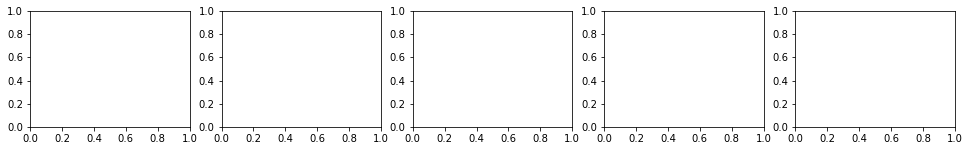

In [13]:
for key in tqdm(data['40']):
    fig,ax = plt.subplots(8,6, sharex = 'col',sharey = 'row', figsize = (20,20), facecolor = 'white')
    rasters = data['40'][key]['rasters']
    counts = data['40'][key]['counts']

    for i,frt in enumerate(stimdict['40']):
        time = stimdict['40'][frt]['time']

        if i ==0:
            ax[0,i].plot(stimdict['40'][frt]['stimtime'],stimdict['40'][frt]['stimulus'], color = 'k')
            ax[0,i].set_title(f' {frt} Hz stimulus \n flash 40 s')
        else:
            ax[0,i].plot(stimdict['40'][frt]['stimtime'],stimdict['40'][frt]['stimulus'], color = 'k')
            ax[0,i].set_title(f' {frt} Hz stimulus \n flash 40 s')


        ax[1,i].eventplot(rasters[i], color = 'k')
        ax[1,i].set_title(f'rasters', loc = 'left')

        ax[2,i].plot(time,counts[i], color = 'k')
        ax[2,i].set_title(f'PSTH', loc = 'left')

        
        seuil = np.mean(counts[i][:50])+ 3*np.std(counts[i][:50])

        peaks,heights = find_peaks(counts[i], height = seuil)

        try:
            first = [time[peaks[0]], heights['peak_heights'][0]]
        except:
            first = [np.nan,np.nan]


        try:
            if len(peaks)>2:
                second = [time[peaks[1]], heights['peak_heights'][1]]
            else:
                second = [np.nan,np.nan]

                
        except:
            second = [np.nan,np.nan]

        try:
            recovery = [time[peaks[-1]], heights['peak_heights'][-1]]
        except:
            recovery = [np.nan,np.nan]


        try:
            last = [[time[peaks[6]],time[peaks[7]],time[peaks[8]]], [heights['peak_heights'][6],heights['peak_heights'][7],heights['peak_heights'][8]]]
            last_mean = [np.mean([time[peaks[6]],time[peaks[7]],time[peaks[8]]]), np.mean([heights['peak_heights'][6],heights['peak_heights'][7],heights['peak_heights'][8]])]
        except:
            last = [[np.nan,np.nan],[np.nan,np.nan],[np.nan,np.nan]]
            last_mean = [np.nan,np.nan]


        pp = second[1]-first[1]
        ti = last_mean[1]-first[1]
        r = recovery[1]-first[1]

        ax[2,i].scatter(first[0],first[1], color = 'r')
        ax[2,i].scatter(second[0],second[1], color = 'b')
        ax[2,i].scatter(recovery[0],recovery[1], color = 'g')
        ax[2,i].scatter(last[0],last[1], color = 'lightblue')

        # print values 
        ax[3,i].axis('off')
        ax[3,i].text(0.0,0.8,f'pp = {np.round(pp,2)} ',fontsize = fontsize, color = 'b')
        ax[3,i].text(0.0,0.6,f'ti = {np.round(ti,2)} ',fontsize = fontsize, color = 'lightblue')
        ax[3,i].text(0.0,0.4,f'r = {np.round(r,2)} ',fontsize = fontsize, color = 'green')


        # save values
        data['40'][key]['first'] = first
        data['40'][key]['second'] = second
        data['40'][key]['last'] = last
        data['40'][key]['recovery'] = recovery

        data['40'][key]['pp'] = pp
        data['40'][key]['ti'] = ti
        data['40'][key]['r'] = r



    rasters = data['eq'][key]['rasters']
    counts = data['eq'][key]['counts']
    for i,frt in enumerate(stimdict['40']):
        time = stimdict['eq'][frt]['time']
        if i ==0:
            ax[4,i].plot(stimdict['eq'][frt]['stimtime'],stimdict['eq'][frt]['stimulus'], color = 'orange')
            ax[4,i].set_title(f' {frt} Hz stimulus \n flash period/2')

        else:
            ax[4,i].plot(stimdict['eq'][frt]['stimtime'],stimdict['eq'][frt]['stimulus'], color = 'orange')
            ax[4,i].set_title(f' {frt} Hz stimulus \n flash period/2')

        ax[5,i].eventplot(rasters[i], color = 'orange')
        ax[5,i].set_title(f'rasters', loc = 'left')


        ax[6,i].plot(time,counts[i], color = 'orange')
        ax[6,i].set_title(f'PSTH', loc = 'left')

        ax[-1,i].set_xlabel('time [s]')

        seuil = np.mean(counts[i][:50])+ 3*np.std(counts[i][:50])

        peaks,heights = find_peaks(counts[i], height = seuil)

        try:
            first = [time[peaks[0]], heights['peak_heights'][0]]
        except:
            first = [np.nan,np.nan]


        try:
            if len(peaks)>2:
                second = [time[peaks[1]], heights['peak_heights'][1]]
            else:
                second = [np.nan,np.nan]

                
        except:
            second = [np.nan,np.nan]

        try:
            recovery = [time[peaks[-1]], heights['peak_heights'][-1]]
        except:
            recovery = [np.nan,np.nan]


        try:
            last = [[time[peaks[6]],time[peaks[7]],time[peaks[8]]], [heights['peak_heights'][6],heights['peak_heights'][7],heights['peak_heights'][8]]]
            last_mean = [np.mean([time[peaks[6]],time[peaks[7]],time[peaks[8]]]), np.mean([heights['peak_heights'][6],heights['peak_heights'][7],heights['peak_heights'][8]])]
        except:
            last = [[np.nan,np.nan],[np.nan,np.nan],[np.nan,np.nan]]
            last_mean = [np.nan,np.nan]


        pp = second[1]-first[1]
        ti = last_mean[1]-first[1]
        r = recovery[1]-first[1]

        ax[6,i].scatter(first[0],first[1], color = 'r')
        ax[6,i].scatter(second[0],second[1], color = 'b')
        ax[6,i].scatter(recovery[0],recovery[1], color = 'g')
        ax[6,i].scatter(last[0],last[1], color = 'lightblue')

        # print values 
        ax[7,i].axis('off')
        ax[7,i].text(0.0,0.8,f'pp = {np.round(pp,2)} ',fontsize = fontsize, color = 'b')
        ax[7,i].text(0.0,0.6,f'ti = {np.round(ti,2)} ',fontsize = fontsize, color = 'lightblue')
        ax[7,i].text(0.0,0.4,f'r = {np.round(r,2)} ',fontsize = fontsize, color = 'green')


        # save values
        data['eq'][key]['first'] = first
        data['eq'][key]['second'] = second
        data['eq'][key]['last'] = last
        data['eq'][key]['recovery'] = recovery

        data['eq'][key]['pp'] = pp
        data['eq'][key]['ti'] = ti
        data['eq'][key]['r'] = r



    ax[1,0].set_ylabel('trial')
    ax[5,0].set_ylabel('trial')

    ax[2,0].set_ylabel('Firing Rate')
    ax[6,0].set_ylabel('Firing Rate')

    #fig.legend()

    try:
        if info[key]['type'] =='ON/OFF':
            POL = 'ONOFF'
        else: 
            POL = info[key]['type']

                
        if not os.path.isdir(f'{fpplots}/{POL}'):
                os.mkdir(f'{fpplots}/{POL}')

        fig.suptitle(f'{key} {POL}')


        fig.savefig(f'{fpplots}/{POL}/{POL}_{key}', facecolor = 'white')
        plt.close()
    except:
        None
        plt.close()

In [15]:
# save data
with open(fpdata, "wb") as handle:   #Pickling
    pickle.dump(data,handle, protocol=4)


In [ ]:
### STP stim
# fit LN model and simulate STP stim responses 
# test longer flash trians

### tuning curves
# longer grating presentations
# look at degus data 
# M_0605 for luminance effect, save chirp stim 

### anticipation project
# moving bar at different speeds + STP stimulus -> fit model with plasticity for moving bar simulations 




 


